<a href="https://colab.research.google.com/github/brilliantfriezka/Robotics-and-Intelligent-Systems/blob/main/UTS/Codegen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UTS Robotics and Intelligent System**
*   Nama : Brilliant Friezka Aina
*   NIM : 1103194186
*   Kelas : TK-43-GAB

In [1]:
pip install symforce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 82 kB 312 kB/s 
     |████████████████████████████████| 6.5 MB 42.5 MB/s 
     |████████████████████████████████| 1.5 MB 23.6 MB/s 
     |████████████████████████████████| 1.5 MB 50.7 MB/s 
     |████████████████████████████████| 70 kB 4.6 MB/s 
     |████████████████████████████████| 49 kB 3.9 MB/s 
     |████████████████████████████████| 96 kB 3.9 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: sympy
    Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [2]:
import numpy as np
import os
import symforce

symforce.set_symbolic_api("symengine")
symforce.set_log_level("warning")

# https://symforce.org/tutorials/epsilon_tutorial.html
symforce.set_epsilon_to_symbol()

from symforce import codegen
from symforce.codegen import codegen_util
from symforce import ops
import symforce.symbolic as sf
from symforce.values import Values
from symforce.notebook_util import display, display_code, display_code_file

In [3]:
def az_el_from_point(
    nav_T_cam: sf.Pose3, nav_t_point: sf.Vector3, epsilon: sf.Scalar = 0
) -> sf.Vector2:
    """
    Transform a nav point into azimuth / elevation angles in the
    camera frame.

    Args:
        nav_T_cam (sf.Pose3): camera pose in the world
        nav_t_point (sf.Matrix): nav point
        epsilon (Scalar): small number to avoid singularities

    Returns:
        sf.Matrix: (azimuth, elevation)
    """
    cam_t_point = nav_T_cam.inverse() * nav_t_point
    x, y, z = cam_t_point
    theta = sf.atan2(y, x + epsilon)
    phi = sf.pi / 2 - sf.acos(z / (cam_t_point.norm() + epsilon))
    return sf.V2(theta, phi)

In [4]:
az_el_codegen = codegen.Codegen.function(
    func=az_el_from_point,
    config=codegen.CppConfig(),
)
az_el_codegen_data = az_el_codegen.generate_function()

print("Files generated in {}:\n".format(az_el_codegen_data.output_dir))
for f in az_el_codegen_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, az_el_codegen_data.output_dir)))

display_code_file(az_el_codegen_data.generated_files[0], "C++")

Files generated in /tmp/sf_codegen_az_el_from_point_wt9h7hp8:

  |- cpp/symforce/sym/az_el_from_point.h


In [5]:
codegen_with_jacobians = az_el_codegen.with_jacobians(
    which_args=["nav_T_cam", "nav_t_point"],
    include_results=True,
)

data = codegen_with_jacobians.generate_function()
from symforce.notebook_util import display_code_file

display_code_file(data.generated_files[0], "C++")

In [6]:
L = sf.V2.symbolic("L").T
m = sf.V2.symbolic("m").T
ang = sf.V2.symbolic("a").T
dang = sf.V2.symbolic("da").T
g = sf.Symbol("g")

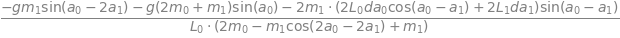

In [7]:
ddang_0 = (
    -g * (2 * m[0] + m[1]) * sf.sin(ang[0])
    - m[1] * g * sf.sin(ang[0] - 2 * ang[1])
    - 2
    * sf.sin(ang[0] - ang[1])
    * m[1]
    * (dang[1] * 2 * L[1] + dang[0] * 2 * L[0] * sf.cos(ang[0] - ang[1]))
) / (L[0] * (2 * m[0] + m[1] - m[1] * sf.cos(2 * ang[0] - 2 * ang[1])))
display(ddang_0)

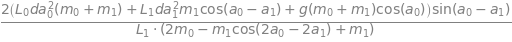

In [8]:
ddang_1 = (
    2
    * sf.sin(ang[0] - ang[1])
    * (
        dang[0] ** 2 * L[0] * (m[0] + m[1])
        + g * (m[0] + m[1]) * sf.cos(ang[0])
        + dang[1] ** 2 * L[1] * m[1] * sf.cos(ang[0] - ang[1])
    )
) / (L[1] * (2 * m[0] + m[1] - m[1] * sf.cos(2 * ang[0] - 2 * ang[1])))
display(ddang_1)

In [9]:
inputs = Values()

inputs["ang"] = ang
inputs["dang"] = dang

with inputs.scope("constants"):
    inputs["g"] = g

with inputs.scope("params"):
    inputs["L"] = L
    inputs["m"] = m

display(inputs)

Values(
  ang: [a0, a1],
  dang: [da0, da1],
  constants:   Values(
    g: g,
  ),
  params:   Values(
    L: [L0, L1],
    m: [m0, m1],
  ),
)

In [10]:
outputs = Values(ddang=sf.V2(ddang_0, ddang_1))

display(outputs)

Values(
  ddang: [(-g*(2*m0 + m1)*sin(a0) + g*sin(-a0 + 2*a1)*m1 + 2*sin(-a0 + a1)*m1*(2*L1*da1 + 2*cos(-a0 + a1)*L0*da0))/(L0*(2*m0 + m1 - cos(-2*a0 + 2*a1)*m1))]
[-2*sin(-a0 + a1)*(g*(m0 + m1)*cos(a0) + (m0 + m1)*L0*da0**2 + cos(-a0 + a1)*m1*L1*da1**2)/(L1*(2*m0 + m1 - cos(-2*a0 + 2*a1)*m1))],
)

In [11]:
double_pendulum = codegen.Codegen(
    inputs=inputs,
    outputs=outputs,
    config=codegen.CppConfig(),
    name="double_pendulum",
    return_key="ddang",
)
double_pendulum_data = double_pendulum.generate_function()

print("Files generated in {}:\n".format(double_pendulum_data.output_dir))
for f in double_pendulum_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, double_pendulum_data.output_dir)))

Files generated in /tmp/sf_codegen_double_pendulum_kbz33tag:

  |- lcmtypes/double_pendulum.lcm
  |- cpp/symforce/sym/double_pendulum.h


In [12]:
display_code_file(double_pendulum_data.function_dir / "double_pendulum.h", "C++")

In [13]:
input_values = Values(inputs=inputs)
output_values = Values(outputs=outputs)
namespace = "double_pendulum"
double_pendulum_values = codegen.Codegen(
    inputs=input_values,
    outputs=output_values,
    config=codegen.CppConfig(),
    name="double_pendulum",
)
double_pendulum_values_data = double_pendulum_values.generate_function(
    namespace=namespace,
)

print("Files generated in {}:\n".format(double_pendulum_values_data.output_dir))
for f in double_pendulum_values_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, double_pendulum_values_data.output_dir)))

display_code_file(
    double_pendulum_values_data.function_dir / "double_pendulum.h",
    "C++",
)

Files generated in /tmp/sf_codegen_double_pendulum_byezx1n3:

  |- lcmtypes/double_pendulum.lcm
  |- cpp/symforce/double_pendulum/double_pendulum.h


In [14]:
namespace = "double_pendulum"
double_pendulum_python = codegen.Codegen(
    inputs=inputs,
    outputs=outputs,
    config=codegen.PythonConfig(use_eigen_types=False),
    name="double_pendulum",
    return_key="ddang",
)
double_pendulum_python_data = double_pendulum_python.generate_function(
    namespace=namespace,
)

print("Files generated in {}:\n".format(double_pendulum_python_data.output_dir))
for f in double_pendulum_python_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, double_pendulum_python_data.output_dir)))

display_code_file(
    double_pendulum_python_data.function_dir / "double_pendulum.py",
    "python",
)

Files generated in /tmp/sf_codegen_double_pendulum_5zfc3z_f:

  |- lcmtypes/double_pendulum.lcm
  |- python/symforce/double_pendulum/double_pendulum.py
  |- python/symforce/double_pendulum/__init__.py


In [15]:
constants_t = codegen_util.load_generated_lcmtype(
    namespace, "constants_t", double_pendulum_python_data.python_types_dir
)

params_t = codegen_util.load_generated_lcmtype(
    namespace, "params_t", double_pendulum_python_data.python_types_dir
)

ang = np.array([[0.0, 0.5]])
dang = np.array([[0.0, 0.0]])
consts = constants_t()
consts.g = 9.81
params = params_t()
params.L = [0.5, 0.3]
params.m = [0.3, 0.2]

gen_module = codegen_util.load_generated_package(
    namespace, double_pendulum_python_data.function_dir
)
gen_module.double_pendulum(ang, dang, consts, params)

array([[  4.77199518],
       [-22.65691471]])